### Importing Libraries 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings 
warnings.filterwarnings("ignore")

### Loading Data

In [4]:
df = pd.read_csv('Spotify_data.csv')
print("Spotify data loaded successfully.")

Spotify data loaded successfully.


In [5]:
print(df.head())
print("\nData Info:")
df.info()

     Age  Gender spotify_usage_period  \
0  20-35  Female    More than 2 years   
1  12-20    Male    More than 2 years   
2  35-60  Others   6 months to 1 year   
3  20-35  Female    1 year to 2 years   
4  20-35  Female    1 year to 2 years   

                         spotify_listening_device spotify_subscription_plan  \
0              Smart speakers or voice assistants       Free (ad-supported)   
1                              Computer or laptop       Free (ad-supported)   
2              Smart speakers or voice assistants       Free (ad-supported)   
3  Smartphone, Smart speakers or voice assistants       Free (ad-supported)   
4                                      Smartphone       Free (ad-supported)   

  premium_sub_willingness          preffered_premium_plan  \
0                     Yes        Family Plan-Rs 179/month   
1                     Yes  Individual Plan- Rs 119/ month   
2                     Yes        Student Plan-Rs 59/month   
3                      No         

In [6]:
df.tail()

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
515,20-35,Female,More than 2 years,"Smartphone, Computer or laptop, Wearable devices",Free (ad-supported),Yes,Student Plan-Rs 59/month,Music,Pop,Morning,"Uplifting and motivational, Sadness or melancholy",While Traveling,recommendations,5,Rarely,Lifestyle and Health,Conversational,Both,Shorter,Ok
516,20-35,Female,More than 2 years,"Smartphone, Computer or laptop",Free (ad-supported),Yes,Student Plan-Rs 59/month,Music,Pop,Night,"Relaxation and stress relief, Uplifting and mo...","While Traveling, Workout session, leisure time",Others,2,Rarely,Comedy,Story telling,Both,Shorter,Ok
517,20-35,Female,More than 2 years,Smartphone,Free (ad-supported),No,Student Plan-Rs 59/month,Music,Pop,Night,Relaxation and stress relief,leisure time,recommendations,3,Never,NaN,Story telling,Both,Shorter,Ok
518,20-35,Female,6 months to 1 year,Smartphone,Premium (paid subscription),Yes,Individual Plan- Rs 119/ month,Music,Melody,Night,"Relaxation and stress relief, Uplifting and mo...","Workout session, leisure time","recommendations, Others",2,Several times a week,Comedy,Conversational,Both,Longer,Satisfied
519,20-35,Female,More than 2 years,"Smartphone, Computer or laptop",Premium (paid subscription),Yes,Student Plan-Rs 59/month,Music,Pop,Night,"Relaxation and stress relief, Sadness or melan...","Office hours,Study Hours, While Traveling, lei...","Playlists, Radio",3,Never,NaN,NaN,NaN,NaN,Ok


In [7]:
df.shape

(520, 20)

In [8]:
df.describe()

,music_recc_rating
count,520.000000
mean,3.503846
std,0.979552
min,1.000000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


In [9]:
df.isnull().sum()

Age                              0
Gender                           0
spotify_usage_period             0
spotify_listening_device         0
spotify_subscription_plan        0
premium_sub_willingness          0
preffered_premium_plan         208
preferred_listening_content      0
fav_music_genre                  0
music_time_slot                  0
music_Influencial_mood           0
music_lis_frequency              0
music_expl_method                0
music_recc_rating                0
pod_lis_frequency                0
fav_pod_genre                  148
preffered_pod_format           140
pod_host_preference            141
preffered_pod_duration         129
pod_variety_satisfaction         0
dtype: int64

### EDA 

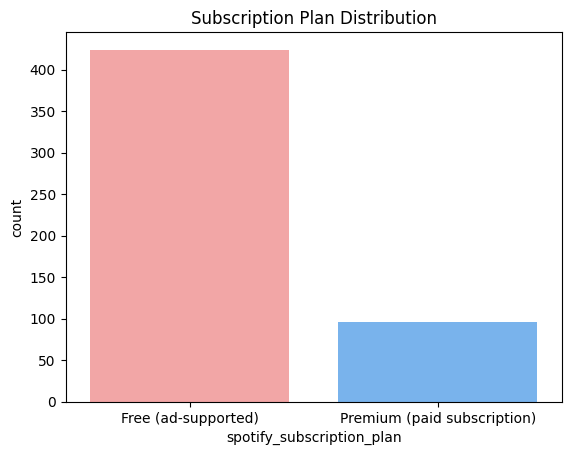

In [11]:
custom_colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99'] 
sns.countplot(x='spotify_subscription_plan', data=df , palette=custom_colors)
plt.title("Subscription Plan Distribution")
plt.show()

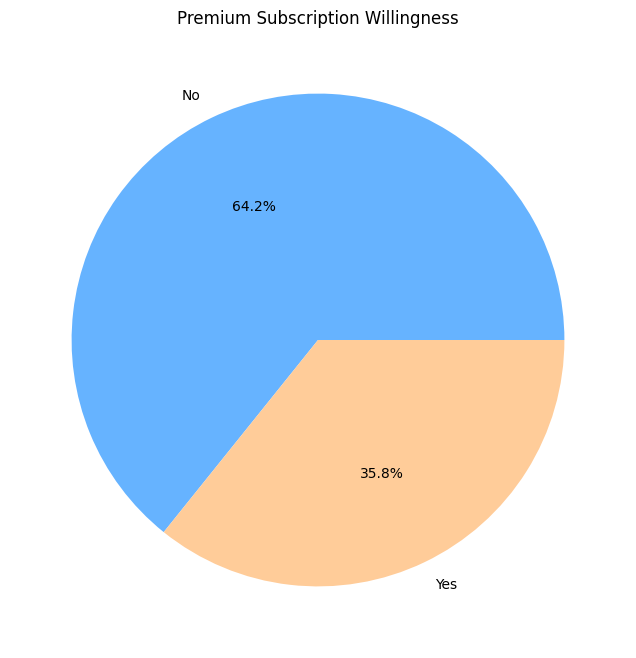

In [12]:
custom_colors = ['#66b3ff', '#ffcc99', '#ff9999']  
plt.figure(figsize=(8, 8))
df['premium_sub_willingness'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=custom_colors
)
plt.title('Premium Subscription Willingness')
plt.ylabel('') 
plt.show()

### Data Cleaning 

In [14]:
# Feature Engineering / Cleaning for Churn Inference
# Convert 'Age' ranges to numerical midpoints
def convert_age_to_numeric(age_range):
    if isinstance(age_range, str):
        if '-' in age_range:
            parts = age_range.split('-')
            return (int(parts[0]) + int(parts[1])) / 2
        elif '+' in age_range:
            return int(age_range.replace('+', '')) + 5
        else:
            return np.nan # Handle unexpected formats
    return age_range

In [15]:
df['Age_Numeric'] = df['Age'].apply(convert_age_to_numeric)
# Fill any NaN in Age_Numeric with the mean or median 
df['Age_Numeric'] = df['Age_Numeric'].fillna(df['Age_Numeric'].mean())

In [16]:
# Convert music_recc_rating to numeric, coercing errors to NaN and filling with 0
df['music_recc_rating'] = pd.to_numeric(df['music_recc_rating'], errors='coerce').fillna(0)

In [17]:
# Infer 'Churn' column based on Spotify-specific indicators
# Initialize Churn column to 0 (No Churn)
df['Churn'] = 0

In [18]:
# Short usage period on free plan
df.loc[(df['spotify_usage_period'] == 'Less than 6 months') &
       (df['spotify_subscription_plan'] == 'Free (ad-supported)'), 'Churn'] = 1

# Unwilling to pay AND free plan AND very low engagement
df.loc[(df['premium_sub_willingness'] == 'No') &
       (df['spotify_subscription_plan'] == 'Free (ad-supported)') &
       ((df['music_lis_frequency'] == 'Never') | (df['pod_lis_frequency'] == 'Never')), 'Churn'] = 1

# Explicit dissatisfaction with podcast variety
df.loc[(df['pod_variety_satisfaction'] == 'Very Dissatisfied') |
       (df['pod_variety_satisfaction'] == 'Dissatisfied'), 'Churn'] = 1

# Very low music recommendation rating
df.loc[df['music_recc_rating'] == 1, 'Churn'] = 1


print("\n'Churn' column created. Churn distribution:")
print(df['Churn'].value_counts())
print(f"Churn percentage: {df['Churn'].value_counts(normalize=True)[1]*100:.2f}%")


'Churn' column created. Churn distribution:
Churn
0    338
1    182
Name: count, dtype: int64
Churn percentage: 35.00%


In [19]:
# Separate target variable (y) from features (X)
# Drop original 'Age' column 
X = df.drop(['Age', 'Churn'], axis=1) # Drop 'Age' and 'Churn'
y = df['Churn']

# Identify categorical and numerical features for the Spotify dataset
numerical_features = ['Age_Numeric', 'music_recc_rating']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")


Categorical features: ['Gender', 'spotify_usage_period', 'spotify_listening_device', 'spotify_subscription_plan', 'premium_sub_willingness', 'preffered_premium_plan', 'preferred_listening_content', 'fav_music_genre', 'music_time_slot', 'music_Influencial_mood', 'music_lis_frequency', 'music_expl_method', 'pod_lis_frequency', 'fav_pod_genre', 'preffered_pod_format', 'pod_host_preference', 'preffered_pod_duration', 'pod_variety_satisfaction']
Numerical features: ['Age_Numeric', 'music_recc_rating']


### Data Preprocessing

In [21]:
# preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Train Test Split

In [23]:
# Train-Test Split
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Splitting data into training and testing sets...
X_train shape: (416, 20), y_train shape: (416,)
X_test shape: (104, 20), y_test shape: (104,)


### Defining Models 

In [25]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

### Model Training and Evaluation 

In [27]:
# StratifiedKFold for cross-validation to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    # pipeline that includes preprocessing, SMOTE, and the classifier
    # Using ImbPipeline from imblearn to correctly handle SMOTE within the pipeline
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)), # SMOTE to balance the training data
        ('classifier', model)
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)


--- Training Decision Tree ---

--- Training Random Forest ---

--- Training XGBoost ---


In [28]:
# Save the trained pipeline using pickle
model_filename = f'{name.lower().replace(" ", "_")}_churn_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(pipeline, f)
print(f"Model saved as {model_filename}")

Model saved as xgboost_churn_model.pkl


In [29]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

In [30]:
# Evaluate the model
print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\n{name} ROC AUC Score: {roc_auc:.4f}")


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.97      0.99        36

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104


XGBoost Confusion Matrix:
 [[68  0]
 [ 1 35]]

XGBoost ROC AUC Score: 1.0000


In [31]:
results[name] = {
    'report': classification_report(y_test, y_pred, output_dict=True),
    'confusion_matrix': confusion_matrix(y_test, y_pred),
    'roc_auc': roc_auc,
    'y_pred': y_pred,
    'y_proba': y_proba
}

    # Cross-validation for robust evaluation
print(f"\nPerforming 5-fold Stratified Cross-Validation for {name}...")
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean CV ROC AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


Performing 5-fold Stratified Cross-Validation for XGBoost...
Cross-Validation ROC AUC Scores: [1.         0.9995915  0.98488562 1.         1.        ]
Mean CV ROC AUC: 0.9969 (+/- 0.0060)


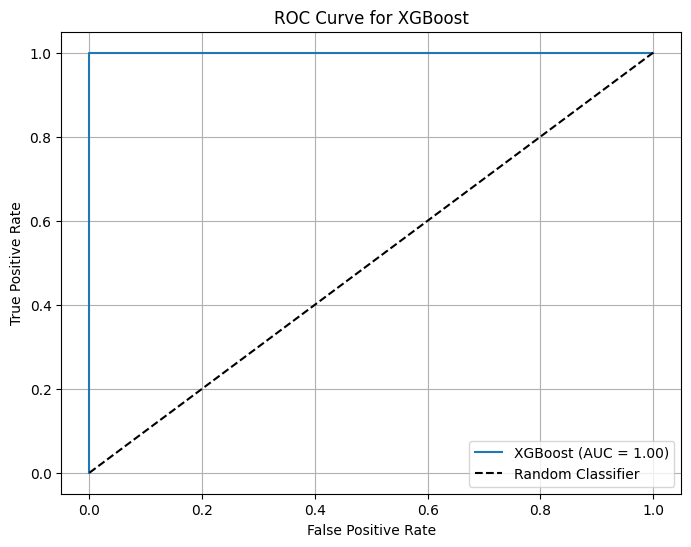

In [32]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
print(" Model Training and Evaluation Complete")

 Model Training and Evaluation Complete


### Exporting Data for Power BI 

In [35]:
results_df = X_test.copy()
results_df['Actual_Churn'] = y_test
results_df['Predicted_Churn'] = y_pred
results_df['Churn_Probability'] = y_proba

# Export the DataFrame to a CSV file
output_csv_filename = 'spotify_churn_predictions.csv'
results_df.to_csv(output_csv_filename, index=False)

print(f"Prediction results saved to {output_csv_filename}")

Prediction results saved to spotify_churn_predictions.csv
